# BLE Proximity Experiment - SVM Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [53]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,0-1 meters,0.0
1,0.0,0.0,-46,-46.500000,0-1 meters,0.0
2,0.0,0.0,-46,-46.333333,0-1 meters,0.0
3,0.0,0.0,-47,-46.500000,0-1 meters,0.0
4,0.0,0.0,-47,-46.600000,0-1 meters,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,3-4 meters,3.5
12471,0.0,3.5,-87,-84.684211,3-4 meters,3.5
12472,0.0,3.5,-87,-84.800000,3-4 meters,3.5
12473,0.0,3.5,-87,-84.904762,3-4 meters,3.5


(12475, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,3-4 meters,3.5
411,0.0,3.5,-88,-84.500000,3-4 meters,3.5
412,0.0,3.5,-84,-84.428571,3-4 meters,3.5
413,0.0,3.5,-83,-84.250000,3-4 meters,3.5


(415, 6)

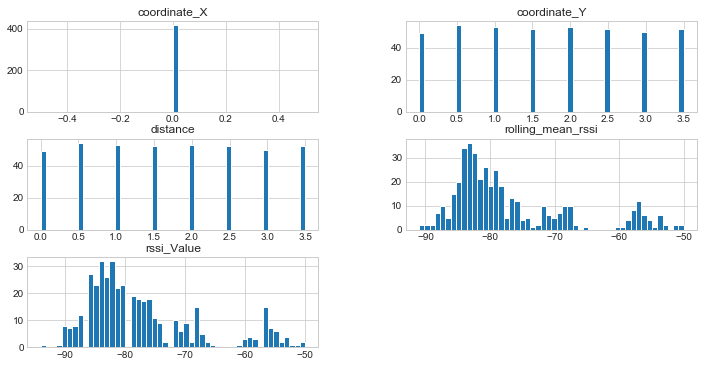

In [5]:
test_dataset = load_file('../../distance_proximity_experiments-checkpoint.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (My Device)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,0-1 meters,0.0
1,0.0,0.0,-44,-44.000000,0-1 meters,0.0
2,0.0,0.0,-44,-44.000000,0-1 meters,0.0
3,0.0,0.0,-44,-44.000000,0-1 meters,0.0
4,0.0,0.0,-45,-44.200000,0-1 meters,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,3-4 meters,3.5
2280,0.0,3.5,-85,-84.000000,3-4 meters,3.5
2281,0.0,3.5,-85,-84.050000,3-4 meters,3.5
2282,0.0,3.5,-92,-84.428571,3-4 meters,3.5


(2284, 6)

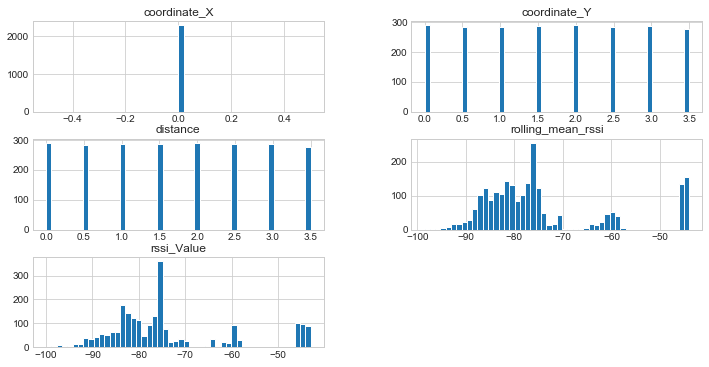

In [6]:
test_dataset_my_device = load_file('../../dataset_test.csv')
positions = test_dataset_my_device['coordinate_Y']
test_dataset_my_device['distance'] = positions
replace_features_nan(test_dataset_my_device)
display(test_dataset_my_device)
display(test_dataset_my_device.shape)
test_dataset_my_device.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [7]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12475 entries, 0 to 12474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       12475 non-null  float64
 1   coordinate_Y       12475 non-null  float64
 2   rssi_Value         12475 non-null  int64  
 3   rolling_mean_rssi  12475 non-null  float64
 4   zone               12475 non-null  object 
 5   distance           12475 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 584.9+ KB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [8]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,12475.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0
coordinate_Y,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5
rssi_Value,12475.0,-73.416754,12.929039,-102.0,-82.0,-76.000000,-64.00,-45.0
rolling_mean_rssi,12475.0,-73.454044,12.766312,-98.5,-82.2,-76.285714,-63.75,-46.0
distance,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5


### % of Missing Values

In [9]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [10]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

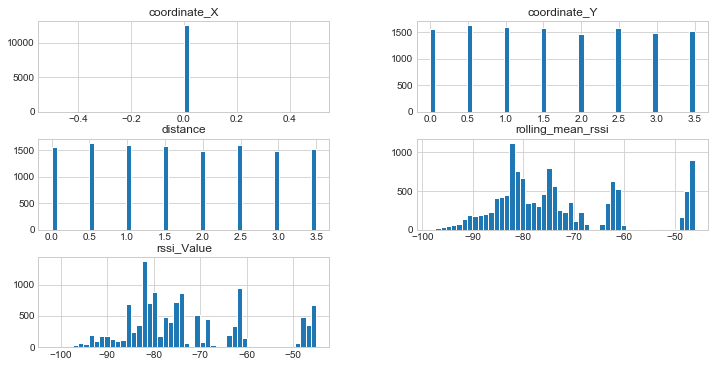

In [11]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

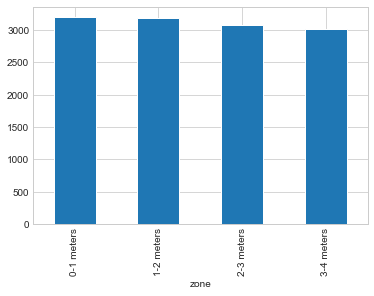

In [12]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

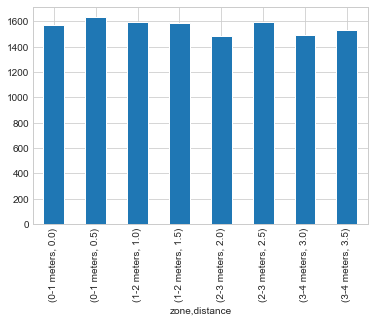

In [13]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

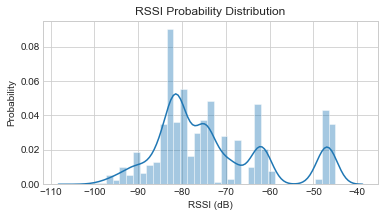

In [14]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

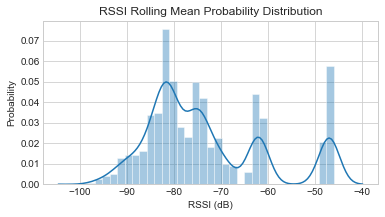

In [15]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

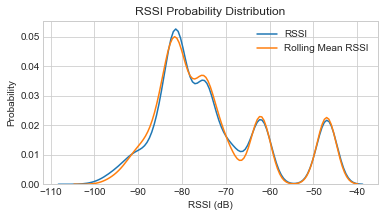

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [17]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.864615,-0.873980,1.000000
rssi_Value,NaN,-0.864615,1.000000,0.981441,-0.864615
rolling_mean_rssi,NaN,-0.873980,0.981441,1.000000,-0.873980
distance,NaN,1.000000,-0.864615,-0.873980,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.864615
rolling_mean_rssi   -0.873980
coordinate_X              NaN
Name: distance, dtype: float64

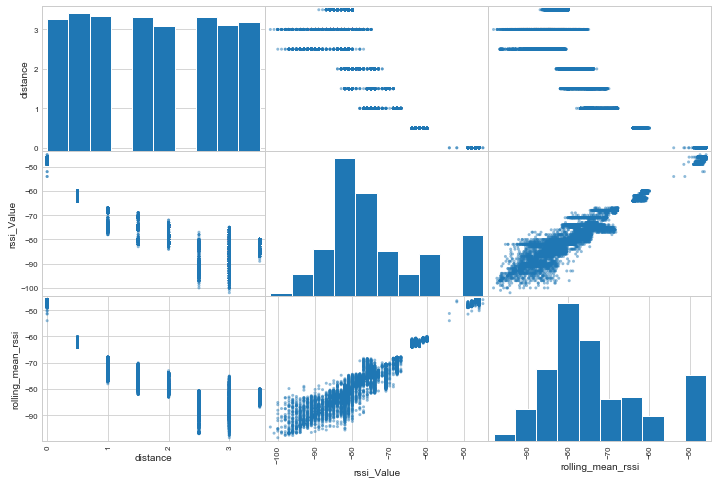

In [18]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [19]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [20]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_my_device,'rssi_Value')
compute_data_cleaning(test_dataset_my_device,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [21]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [22]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
12470,3-4 meters
12471,3-4 meters
12472,3-4 meters
12473,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0],
       [0],
       [0],
       ...,
       [3],
       [3],
       [3]])

In [23]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
410,3-4 meters
411,3-4 meters
412,3-4 meters
413,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(415, 1)

In [24]:
categorical_zone = test_dataset_my_device[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_my_device['labels'] = test_changed
test_Y_my_device = test_dataset_my_device['labels'].values.reshape(-1,1)
display(test_Y_my_device.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
2279,3-4 meters
2280,3-4 meters
2281,3-4 meters
2282,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2284, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [25]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [26]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-54.656250,-54.714171
1-2 meters,-73.941824,-73.986266
2-3 meters,-81.840872,-81.883638
3-4 meters,-84.163468,-84.165817


### Plot Training Data
Graphical Display of the observations in the dataset

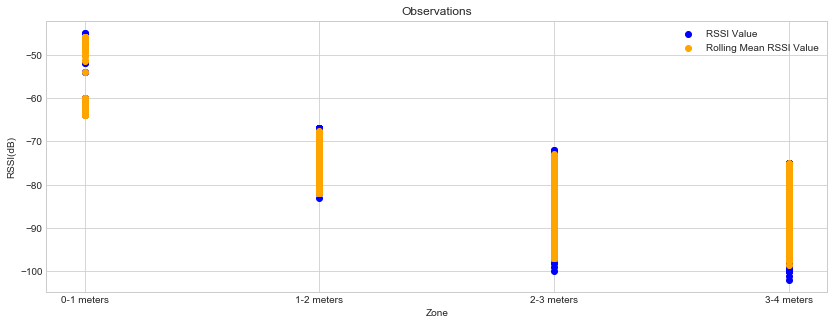

In [27]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [28]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(415, 1)

(415, 1)

(415, 2)

In [29]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-63.223301,-63.123000
1-2 meters,-79.533333,-79.841372
2-3 meters,-82.171429,-81.838530
3-4 meters,-84.215686,-83.930766


In [30]:
test_X_rssi_my_device = pd.DataFrame(test_dataset_my_device['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_my_device.shape)
test_X_rolling_mean_my_device = pd.DataFrame(test_dataset_my_device['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_my_device.shape)
test_combination_features_X_my_device = test_dataset_my_device[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_my_device.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [31]:
data_plot_means = test_dataset_my_device.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-55.246503,-55.259603
1-2 meters,-78.954545,-79.459584
2-3 meters,-77.871080,-77.982160
3-4 meters,-85.335689,-85.247963


### Plot Test Data

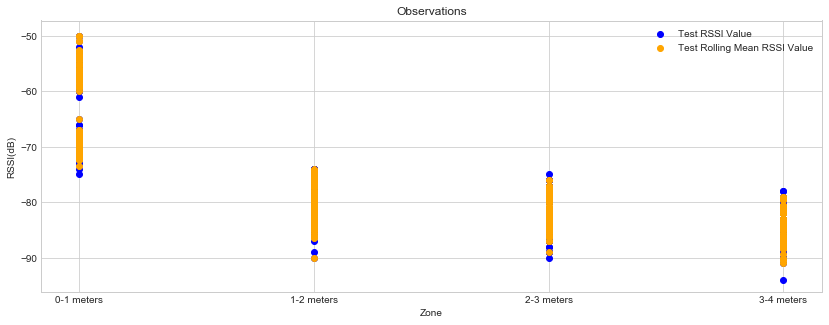

In [32]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

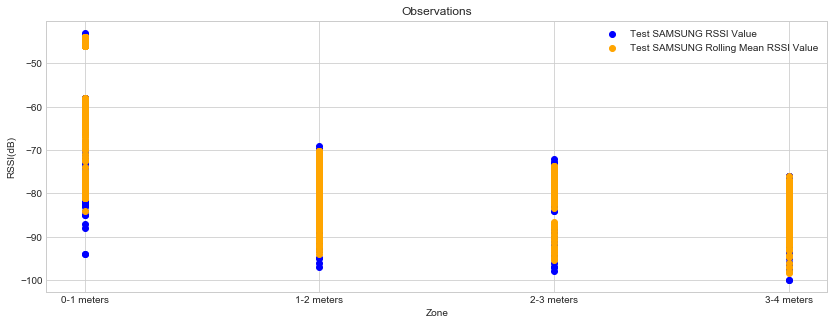

In [33]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [34]:
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
C_parameter_list = [0.25,0.5,1.0,10.0,100.0,1000.0] 
kernel_list = ("linear","poly","rbf","sigmoid")
gamma_list = [10,100,"scale","auto"]
class_weights_list = ["balanced",None]
decision_function_shape_list = ["ovo","ovr"]

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [35]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.44574947, 0.55425053])

rolling_mean_rssi    0.554251
rssi_Value           0.445749
dtype: float64

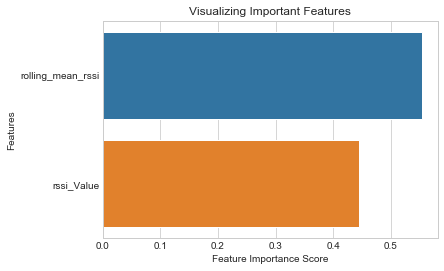

In [36]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - SVM Classification Model
Experiments with SVC algorithm

In [37]:
def compute_SVM_with_Classifier(flag=0,colors=None,trainX_data = None,fold=None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                                cross_validation = None,C_parameter = 1.0, kernel_parameter='rbf', gamma_parameter="scale",
                                class_weigth_parameter=None, decision_function_shape_parameter='ovr'):
    svm_classifier_estimator = SVC(C=C_parameter,kernel=kernel_parameter,gamma=gamma_parameter,class_weight=class_weigth_parameter,
                                  decision_function_shape=decision_function_shape_parameter,random_state = 42)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,svm_classifier_estimator)
    else:
        main_estimator = svm_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

#### Check Training model with no cross validation 
Use SVM Classifier to check the results on the training data alone

Confusion Matrix:
[[3200    0    0    0]
 [   0 2678  465   37]
 [   0  940  455 1678]
 [   0  221  844 1957]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.697577,0.842138,0.763072,3180.000000
2,0.257937,0.148064,0.188133,3073.000000
3,0.532952,0.647584,0.584703,3022.000000
accuracy,0.664529,0.664529,0.664529,0.664529
macro avg,0.622117,0.659447,0.633977,12475.000000
weighted avg,0.626975,0.664529,0.639012,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Confusion Matrix:
[[3200    0    0    0]
 [   0 2813  284   83]
 [   0  765  335 1973]
 [   0  120  270 2632]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.00000
1,0.760681,0.884591,0.817970,3180.00000
2,0.376828,0.109014,0.169107,3073.00000
3,0.561433,0.870946,0.682750,3022.00000
accuracy,0.719840,0.719840,0.719840,0.71984
macro avg,0.674736,0.716138,0.667457,12475.00000
weighted avg,0.679247,0.719840,0.672071,12475.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Confusion Matrix:
[[3200    0    0    0]
 [   0 2848   95  237]
 [   0  675  354 2044]
 [   0   90  122 2810]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.788265,0.895597,0.838510,3180.000000
2,0.619965,0.115197,0.194292,3073.000000
3,0.551954,0.929848,0.692715,3022.000000
accuracy,0.738437,0.738437,0.738437,0.738437
macro avg,0.740046,0.735161,0.681379,12475.000000
weighted avg,0.743875,0.738437,0.685924,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.261563,0.261563,0.511432,0.740363,0.738437,0.690180,Both
1,0.280160,0.280160,0.529302,0.681824,0.719840,0.675599,Rolling Mean RSSI
0,0.335471,0.335471,0.579199,0.628870,0.664529,0.639061,RSSI Only


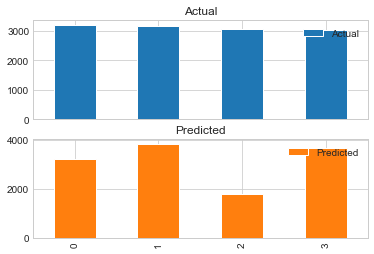

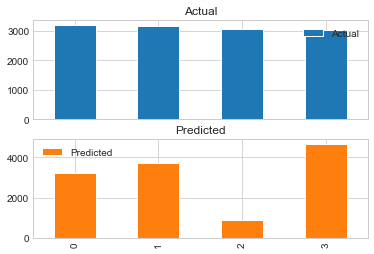

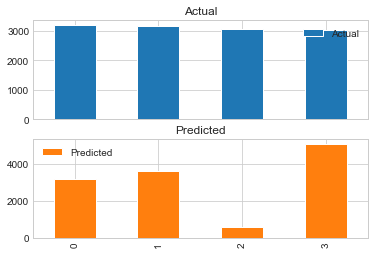

In [38]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = compute_SVM_with_Classifier(flag=1,trainX_data=trainX_data,trainY_data=train_Y.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - SVM with StratifiedKFold 
Experiment using cross validation approach of StratifiedKFold

,mae,mse,rmse,precision,accuracy,f1-score,folds,type
2,0.368176,0.368176,0.606775,0.601221,0.631824,0.611414,4,RSSI Only
11,0.352545,0.352545,0.593755,0.590518,0.647455,0.610996,5,Both
9,0.362405,0.362405,0.602001,0.589955,0.637595,0.607233,3,Both
5,0.366253,0.366253,0.605188,0.590854,0.633747,0.606335,3,Rolling Mean RSSI
1,0.366733,0.366733,0.605585,0.591426,0.633267,0.606266,3,RSSI Only
7,0.359840,0.359840,0.599866,0.581296,0.640160,0.603440,5,Rolling Mean RSSI
3,0.376754,0.376754,0.613802,0.577037,0.623246,0.593805,5,RSSI Only
10,0.368818,0.368818,0.607304,0.567651,0.631182,0.592777,4,Both
6,0.375311,0.375311,0.612626,0.566080,0.624689,0.589193,4,Rolling Mean RSSI
0,0.436072,0.436072,0.660358,0.581984,0.563928,0.559198,2,RSSI Only


Number of Folds:  4


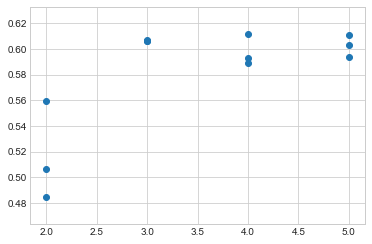

In [39]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for cv in cross_validation_list:
        result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['folds'],statistics['f1-score'])
selected_fold = statistics.sort_values(by=['f1-score'],ascending=False)['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - SVM with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size,type
19,0.267335,0.267335,0.517044,0.726698,0.732665,0.687206,0.2,Both
20,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,0.3,Both
18,0.269231,0.269231,0.518875,0.732870,0.730769,0.684550,0.1,Both
23,0.266132,0.266132,0.515880,0.730028,0.733868,0.683725,0.6,Both
21,0.266132,0.266132,0.515880,0.734710,0.733868,0.682766,0.4,Both
22,0.266752,0.266752,0.516481,0.729762,0.733248,0.682627,0.5,Both
17,0.281083,0.281083,0.530173,0.686057,0.718917,0.682382,0.9,Rolling Mean RSSI
24,0.268293,0.268293,0.517970,0.718952,0.731707,0.682250,0.7,Both
16,0.280160,0.280160,0.529302,0.685220,0.719840,0.681680,0.8,Rolling Mean RSSI
14,0.273614,0.273614,0.523081,0.694743,0.726386,0.680110,0.6,Rolling Mean RSSI


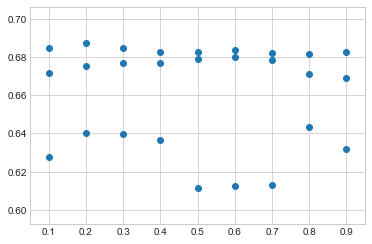

In [40]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=train_Y)
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['test_size'],statistics['f1-score'])

#### Experiment - SVM with Leave One Group Out (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [41]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

,mae,mse,rmse,precision,accuracy,f1-score,type
0,1.0,1.0,1.0,0.0,0.0,0.0,RSSI Only
1,1.0,1.0,1.0,0.0,0.0,0.0,Rolling Mean RSSI
2,1.0,1.0,1.0,0.0,0.0,0.0,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using SVM

,mae,mse,rmse,precision,accuracy,f1-score,method,type
7,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,HoldOut,Both
4,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,HoldOut,Rolling Mean RSSI
1,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,HoldOut,RSSI Only
2,0.368176,0.368176,0.606775,0.601221,0.631824,0.611414,Stratified K-Fold,RSSI Only
8,0.368818,0.368818,0.607304,0.567651,0.631182,0.592777,Stratified K-Fold,Both
5,0.375311,0.375311,0.612626,0.566080,0.624689,0.589193,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


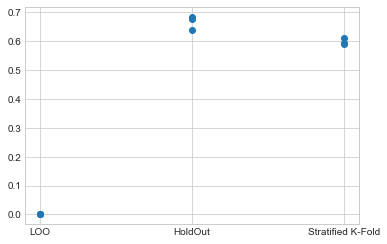

In [42]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
    holdout = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skfold = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['method'],statistics['f1-score'],'o')
selected_method = statistics.sort_values(by=['f1-score'],ascending=False)['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
11,0.266097,0.266097,0.515846,0.736379,0.733903,0.685114,None,None,Both
9,0.266097,0.266097,0.515846,0.737210,0.733903,0.684779,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
8,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
10,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,MaxAbsScaler,MaxAbsScaler(copy=True),Both
4,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
5,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
6,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
7,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,None,None,Rolling Mean RSSI
0,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only


Selected Preprocessing:  None


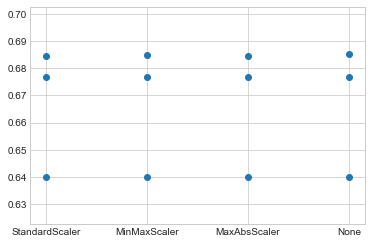

In [43]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['preprocessing'],statistics['f1-score'])
selected_preprocessing = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### Experiment - Running the SVC function with the different kernels

,mae,mse,rmse,precision,accuracy,f1-score,kernel,type
8,0.260219,0.260219,0.510117,0.735838,0.739781,0.735158,linear,Both
4,0.262891,0.262891,0.512729,0.732599,0.737109,0.732145,linear,Rolling Mean RSSI
0,0.286134,0.286134,0.534915,0.710301,0.713866,0.708572,linear,RSSI Only
10,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,rbf,Both
6,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,rbf,Rolling Mean RSSI
2,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,rbf,RSSI Only
5,0.333957,0.333957,0.577890,0.672009,0.666043,0.636017,poly,Rolling Mean RSSI
9,0.337697,0.337697,0.581117,0.669487,0.662303,0.632677,poly,Both
7,0.363345,0.363345,0.602781,0.617248,0.636655,0.623302,sigmoid,Rolling Mean RSSI
1,0.339300,0.339300,0.582495,0.646328,0.660700,0.617330,poly,RSSI Only


Selected Kernel:  linear


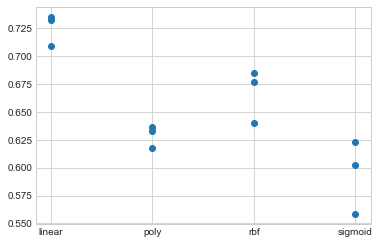

In [45]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','kernel','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for kernel in kernel_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),kernel_parameter=kernel,
                                                 cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),kernel_parameter=kernel,
                                                 cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler = StandardScaler(),kernel_parameter=kernel)
        result.append(kernel)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['kernel'],statistics['f1-score'],'o')
selected_kernel = statistics.sort_values(by=['f1-score'],ascending=False)['kernel'].head(1).values[0]
print("Selected Kernel: ",selected_kernel)

#### 12th Experiment - Running the SVC function with the different C parameters

,mae,mse,rmse,precision,accuracy,f1-score,C_parameter,type
17,0.238846,0.238846,0.488719,0.750425,0.761154,0.745822,1000.00,Both
5,0.266097,0.266097,0.515846,0.746245,0.733903,0.730223,1000.00,RSSI Only
16,0.248197,0.248197,0.498193,0.753693,0.751803,0.721938,100.00,Both
4,0.278119,0.278119,0.527370,0.745127,0.721881,0.716807,100.00,RSSI Only
3,0.290409,0.290409,0.538896,0.719250,0.709591,0.704211,10.00,RSSI Only
15,0.258082,0.258082,0.508017,0.750483,0.741918,0.702524,10.00,Both
11,0.280256,0.280256,0.529393,0.687362,0.719744,0.684855,1000.00,Rolling Mean RSSI
14,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,1.00,Both
13,0.267700,0.267700,0.517397,0.727563,0.732300,0.682483,0.50,Both
12,0.271440,0.271440,0.520999,0.715972,0.728560,0.679425,0.25,Both


Selected C Parameter:  1000.0


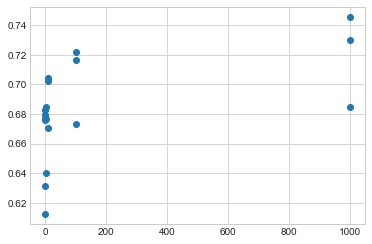

In [47]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','C_parameter','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for C_param in C_parameter_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),C_parameter=C_param,
                                                 cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),C_parameter=C_param,
                                                 cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler = StandardScaler(),C_parameter=C_param)
        result.append(C_param)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['C_parameter'],statistics['f1-score'],'o')
selected_c_parameter = statistics.sort_values(by=['f1-score'],ascending=False)['C_parameter'].head(1).values[0]
print("Selected C Parameter: ",selected_c_parameter)

#### 13th Experiment - Running the SVC function with the different gamma parameters

In [50]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','gamma','gammaStr','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for gamma_param in gamma_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),gamma_parameter=gamma_param,
                                                 cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),gamma_parameter=gamma_param,
                                                 cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler = StandardScaler(),gamma_parameter=gamma_param)
        result.append(gamma_param)
        result.append(str(gamma_param))
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
selected_gamma = statistics.sort_values(by=['f1-score'],ascending=False)['gamma'].head(1).values[0]
print("Selected Gamma: ",selected_gamma)

,mae,mse,rmse,precision,accuracy,f1-score,gamma,gammaStr,type
9,0.151216,0.151216,0.388865,0.846247,0.848784,0.846519,100,100,Both
8,0.170986,0.170986,0.413504,0.826762,0.829014,0.826391,10,10,Both
1,0.217205,0.217205,0.466053,0.779456,0.782795,0.779763,100,100,RSSI Only
0,0.221747,0.221747,0.470900,0.774717,0.778253,0.775104,10,10,RSSI Only
5,0.239113,0.239113,0.488992,0.754551,0.760887,0.752777,100,100,Rolling Mean RSSI
4,0.264494,0.264494,0.514290,0.734811,0.735506,0.694848,10,10,Rolling Mean RSSI
10,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,scale,scale,Both
11,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,auto,auto,Both
6,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,scale,scale,Rolling Mean RSSI
7,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,auto,auto,Rolling Mean RSSI


Selected Gamma:  100


#### 14th Experiment - Running the SVC function with the different weights metrics

,mae,mse,rmse,precision,accuracy,f1-score,class_weights,type
4,0.264494,0.264494,0.514290,0.742525,0.735506,0.687691,balanced,Both
5,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,None,Both
3,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,None,Rolling Mean RSSI
2,0.274646,0.274646,0.524067,0.695330,0.725354,0.676764,balanced,Rolling Mean RSSI
0,0.326476,0.326476,0.571381,0.642631,0.673524,0.651152,balanced,RSSI Only
1,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,None,RSSI Only


Selected Class Weight:  balanced


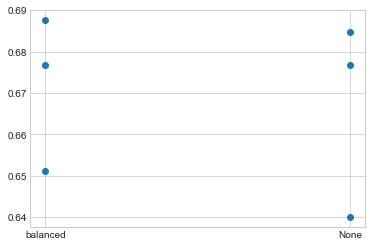

In [51]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','class_weights','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for weight in class_weights_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),class_weigth_parameter=weight,
                                                 cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),class_weigth_parameter=weight,
                                                 cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler = StandardScaler(),class_weigth_parameter=weight)
        result.append(str(weight))
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['class_weights'],statistics['f1-score'],'o')
selected_weight = statistics.sort_values(by=['f1-score'],ascending=False)['class_weights'].head(1).values[0]
print("Selected Class Weight: ",selected_weight)

#### 15th Experiment: Running the SVC function with the different decision function metrics

,mae,mse,rmse,precision,accuracy,f1-score,decision_function,type
4,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,ovo,Both
5,0.266364,0.266364,0.516105,0.735677,0.733636,0.684631,ovr,Both
2,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,ovo,Rolling Mean RSSI
3,0.274379,0.274379,0.523812,0.694156,0.725621,0.676766,ovr,Rolling Mean RSSI
0,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,ovo,RSSI Only
1,0.336628,0.336628,0.580197,0.630215,0.663372,0.639986,ovr,RSSI Only


Selected Decision:  ovo


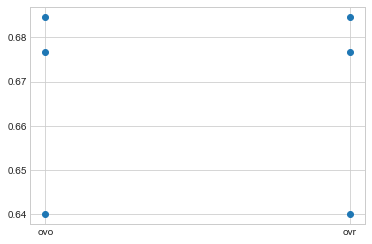

In [52]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','decision_function','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for decision in decision_function_shape_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),decision_function_shape_parameter=decision,
                                                 cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),
                                                 scaler = StandardScaler(),decision_function_shape_parameter=decision,
                                                 cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler = StandardScaler(),decision_function_shape_parameter=decision)
        result.append(str(decision))
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['decision_function'],statistics['f1-score'],'o')
selected_decision = statistics.sort_values(by=['f1-score'],ascending=False)['decision_function'].head(1).values[0]
print("Selected Decision: ",selected_decision)

### Run RandomizedSearchCV for parameter tunning

In [54]:
results = list()
tuned_parameters = {
    'svc__kernel':['rbf'],
    'svc__C':C_parameter_list,
    'svc__gamma':gamma_list
}
scores = ['f1_macro']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for feature in types:
        #Decide on type of data
        if feature == 'RSSI Only':
            trainX_data = train_X_rssi
        elif feature == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X 
        pipe = Pipeline([('standardizer', StandardScaler()), ('svc', SVC())])
        clf = RandomizedSearchCV(
           pipe, param_distributions = tuned_parameters, n_iter = 50, cv=selected_fold,scoring=score,n_jobs=-1,verbose=1
        )
        clf.fit(trainX_data,train_Y.ravel())
        clf.best_params_['score'] = score
        clf.best_params_['best_score'] = clf.best_score_
        clf.best_params_['type'] = feature
        results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results).sort_values(by=['best_score'],ascending=False)
display(gridcv_results)

# Tuning hyper-parameters for f1_macro

Fitting 4 folds for each of 24 candidates, totalling 96 fits


D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.1min finished
D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  6.8min finished
D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.5min finished


,svc__kernel,svc__gamma,svc__C,score,best_score,type
2,rbf,10,1000.0,f1_macro,0.783868,Both
0,rbf,10,1000.0,f1_macro,0.734201,RSSI Only
1,rbf,100,100.0,f1_macro,0.651098,Rolling Mean RSSI


### Best Parameters
Display the best parameters tunned throughout the experiments

In [55]:
conclusion_cols=['C Parameter','Cross Validation','Kernel','Preprocessing','Gamma','Class Weights','Decision Function']
conclusion_list = [selected_c_parameter,selected_method,selected_kernel,selected_preprocessing,selected_gamma,selected_weight,
                  selected_decision]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,C Parameter,Cross Validation,Kernel,Preprocessing,Gamma,Class Weights,Decision Function
0,1000.0,HoldOut,linear,None,100,balanced,ovo


### Best Results
Compute SVC with the best parameters in both RSSI and Rolling Mean

In [60]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
        result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                             cross_validation = splited,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             gamma_parameter=selected_gamma,decision_function_shape_parameter=selected_decision,class_weigth_parameter=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_SVM_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                             cross_validation = selected_fold,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             gamma_parameter=selected_gamma,decision_function_shape_parameter=selected_decision,class_weigth_parameter=selected_weight)
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3,
                                                                                    random_state = 42,stratify=train_Y)
        result = compute_SVM_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             gamma_parameter=selected_gamma,decision_function_shape_parameter=selected_decision,class_weigth_parameter=selected_weight)
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

,mae,mse,rmse,precision,accuracy,f1-score,type
1,0.265562,0.265562,0.515327,0.727958,0.734438,0.729228,Rolling Mean RSSI
2,0.265562,0.265562,0.515327,0.727958,0.734438,0.729228,Both
0,0.328346,0.328346,0.573015,0.635852,0.671654,0.645693,RSSI Only


### Best Results - Testing data (using data recovered from Android 6.0 Asus ZENFONE Live)
Experiment with testing dataset

Confusion Matrix:
[[50 53  0  0]
 [ 0 45 37 23]
 [ 0 24 28 53]
 [ 0  2 31 69]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.362903,0.428571,0.393013,105.000000
2,0.291667,0.266667,0.278607,105.000000
3,0.475862,0.676471,0.558704,102.000000
accuracy,0.462651,0.462651,0.462651,0.462651
macro avg,0.532608,0.464286,0.470980,415.000000
weighted avg,0.530766,0.462651,0.469466,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0 103   0   0]
 [  0 105   0   0]
 [  0 105   0   0]
 [  0 102   0   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.253012,1.000000,0.403846,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.000000,0.000000,0.000000,102.000000
accuracy,0.253012,0.253012,0.253012,0.253012
macro avg,0.063253,0.250000,0.100962,415.000000
weighted avg,0.064015,0.253012,0.102178,415.000000


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
410,3,1
411,3,1
412,3,1
413,3,1


Confusion Matrix:
[[50 53  0  0]
 [ 0 31 51 23]
 [ 0  8 45 52]
 [ 0  0 34 68]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.00000
1,0.336957,0.295238,0.314721,105.00000
2,0.346154,0.428571,0.382979,105.00000
3,0.475524,0.666667,0.555102,102.00000
accuracy,0.467470,0.467470,0.467470,0.46747
macro avg,0.539659,0.468978,0.476599,415.00000
weighted avg,0.537904,0.467470,0.475179,415.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0   0 103   0]
 [  0   0 105   0]
 [  0   0 105   0]
 [  0   0 102   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.253012,1.000000,0.403846,105.000000
3,0.000000,0.000000,0.000000,102.000000
accuracy,0.253012,0.253012,0.253012,0.253012
macro avg,0.063253,0.250000,0.100962,415.000000
weighted avg,0.064015,0.253012,0.102178,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,3,2
411,3,2
412,3,2
413,3,2


Confusion Matrix:
[[50 53  0  0]
 [ 0 32 53 20]
 [ 0 10 45 50]
 [ 0  0 32 70]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.336842,0.304762,0.320000,105.000000
2,0.346154,0.428571,0.382979,105.000000
3,0.500000,0.686275,0.578512,102.000000
accuracy,0.474699,0.474699,0.474699,0.474699
macro avg,0.545749,0.476261,0.483771,415.000000
weighted avg,0.543891,0.474699,0.482268,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0 103   0   0]
 [  0 105   0   0]
 [  0 105   0   0]
 [  0 102   0   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.253012,1.000000,0.403846,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.000000,0.000000,0.000000,102.000000
accuracy,0.253012,0.253012,0.253012,0.253012
macro avg,0.063253,0.250000,0.100962,415.000000
weighted avg,0.064015,0.253012,0.102178,415.000000


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
410,3,1
411,3,1
412,3,1
413,3,1


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
4,0.525301,0.525301,0.724777,0.535333,0.474699,0.482261,Both,True
2,0.532530,0.532530,0.729747,0.529095,0.467470,0.475092,Rolling Mean RSSI,True
0,0.537349,0.537349,0.733041,0.522351,0.462651,0.469574,RSSI Only,True
1,0.746988,0.746988,0.864285,0.090470,0.253012,0.122857,RSSI Only,False
3,0.746988,0.746988,0.864285,0.090470,0.253012,0.122857,Rolling Mean RSSI,False
5,0.746988,0.746988,0.864285,0.090470,0.253012,0.122857,Both,False


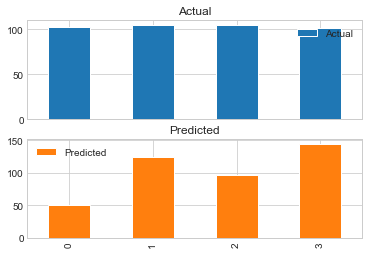

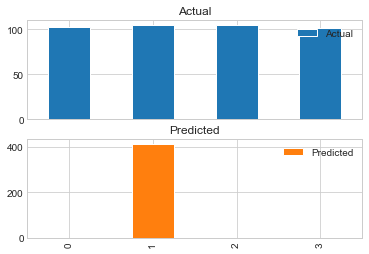

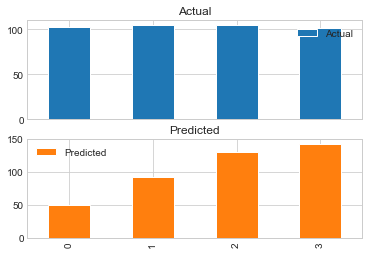

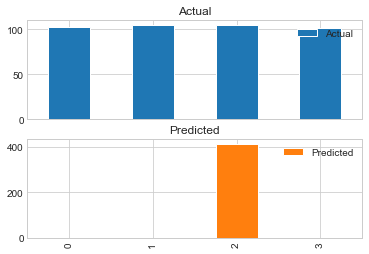

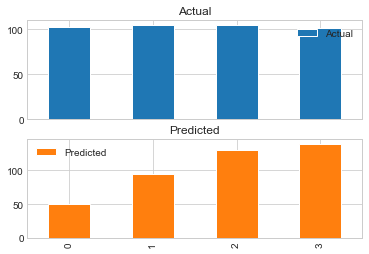

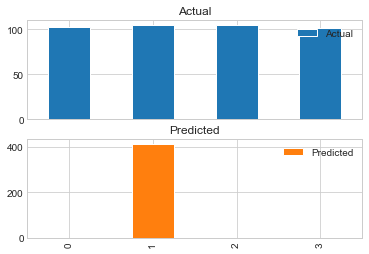

In [57]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = SVC(C=selected_c_parameter,kernel=selected_kernel,gamma=selected_gamma,class_weight=selected_weight,
                                  decision_function_shape=selected_decision,random_state = 42)
        else: 
            model = SVC()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

### Best Results - Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71)
Experiment with testing dataset

Confusion Matrix:
[[490  50  22  10]
 [  0 294 151 127]
 [  0 416 132  26]
 [  0  15 127 424]]


,precision,recall,f1-score,support
0,1.000000,0.856643,0.922787,572.00000
1,0.379355,0.513986,0.436526,572.00000
2,0.305556,0.229965,0.262425,574.00000
3,0.722317,0.749117,0.735473,566.00000
accuracy,0.586690,0.586690,0.586690,0.58669
macro avg,0.601807,0.587428,0.589303,2284.00000
weighted avg,0.601231,0.586690,0.588633,2284.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[  0 572   0   0]
 [  0 572   0   0]
 [  0 574   0   0]
 [  0 566   0   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.250438,1.000000,0.400560,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.000000,0.000000,0.000000,566.000000
accuracy,0.250438,0.250438,0.250438,0.250438
macro avg,0.062609,0.250000,0.100140,2284.000000
weighted avg,0.062719,0.250438,0.100315,2284.000000


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2279,3,1
2280,3,1
2281,3,1
2282,3,1


Confusion Matrix:
[[485  46  40   1]
 [  0 229 169 174]
 [  0 377 172  25]
 [  0   7 105 454]]


,precision,recall,f1-score,support
0,1.000000,0.847902,0.917692,572.00000
1,0.347496,0.400350,0.372055,572.00000
2,0.353909,0.299652,0.324528,574.00000
3,0.694190,0.802120,0.744262,566.00000
accuracy,0.586690,0.586690,0.586690,0.58669
macro avg,0.598899,0.587506,0.589634,2284.00000
weighted avg,0.598434,0.586690,0.588996,2284.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[  0   0 572   0]
 [  0   0 572   0]
 [  0   0 574   0]
 [  0   0 566   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.251313,1.000000,0.401679,574.000000
3,0.000000,0.000000,0.000000,566.000000
accuracy,0.251313,0.251313,0.251313,0.251313
macro avg,0.062828,0.250000,0.100420,2284.000000
weighted avg,0.063158,0.251313,0.100947,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,3,2
2280,3,2
2281,3,2
2282,3,2


Confusion Matrix:
[[487  46  37   2]
 [  0 237 172 163]
 [  0 368 177  29]
 [  0   5 106 455]]


,precision,recall,f1-score,support
0,1.000000,0.851399,0.919736,572.000000
1,0.361280,0.414336,0.385993,572.000000
2,0.359756,0.308362,0.332083,574.000000
3,0.701079,0.803887,0.748971,566.000000
accuracy,0.593695,0.593695,0.593695,0.593695
macro avg,0.605529,0.594496,0.596696,2284.000000
weighted avg,0.605063,0.593695,0.596064,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[  0 572   0   0]
 [  0 572   0   0]
 [  0 574   0   0]
 [  0 566   0   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.250438,1.000000,0.400560,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.000000,0.000000,0.000000,566.000000
accuracy,0.250438,0.250438,0.250438,0.250438
macro avg,0.062609,0.250000,0.100140,2284.000000
weighted avg,0.062719,0.250438,0.100315,2284.000000


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2279,3,1
2280,3,1
2281,3,1
2282,3,1


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
4,0.406305,0.406305,0.637420,0.603772,0.593695,0.596177,Both,True
2,0.413310,0.413310,0.642892,0.597088,0.586690,0.589123,Rolling Mean RSSI,True
0,0.413310,0.413310,0.642892,0.599565,0.586690,0.588834,RSSI Only,True
3,0.748687,0.748687,0.865267,0.089802,0.251313,0.122051,Rolling Mean RSSI,False
1,0.749562,0.749562,0.865773,0.089458,0.250438,0.121636,RSSI Only,False
5,0.749562,0.749562,0.865773,0.089458,0.250438,0.121636,Both,False


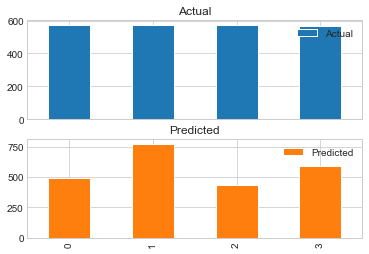

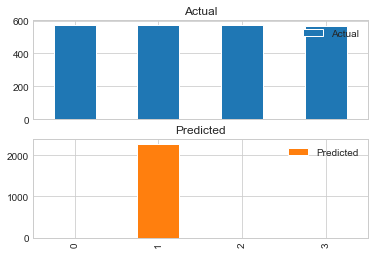

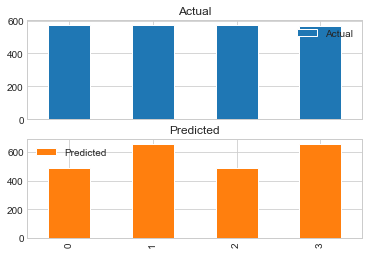

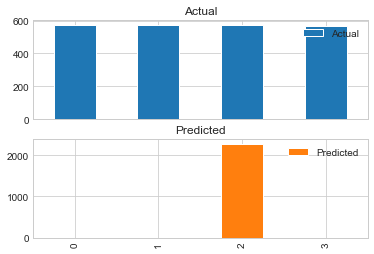

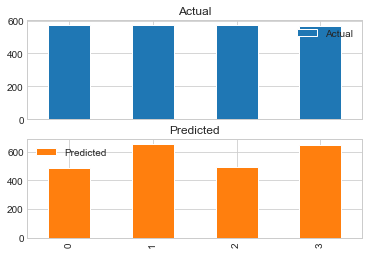

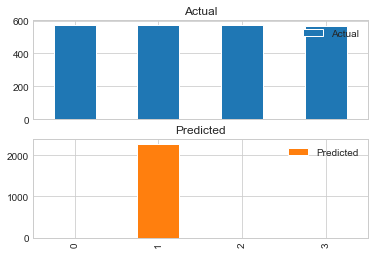

In [62]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_my_device
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_my_device
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_my_device 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = SVC(C=selected_c_parameter,kernel=selected_kernel,gamma=selected_gamma,class_weight=selected_weight,
                                  decision_function_shape=selected_decision,random_state = 42)
        else: 
            model = SVC()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_my_device.ravel(), predicted)
        report = classification_report(test_Y_my_device.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_my_device.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_my_device.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))